In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-04-12 06:40:50.522422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 06:40:50.522550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 06:40:50.674795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = "/kaggle/input/brain-tumor-classification-mri"

images = []
labels = []

def preprocess_image(img):
    img = img/255
    img = np.float32(img)
    img = cv2.resize(img, (224, 224))
    img = img - np.mean(img)
    img = img/np.std(img)
    return img

for data_dir_name in os.listdir(dataset):
    # training or testing directory
    data_dir = os.path.join(dataset, data_dir_name)
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_dir = os.path.join(label_dir, img_name)
            img = cv2.imread(img_dir)
            img = preprocess_image(img)
            images.append(img)
            labels.append(label)
            
images = np.asarray(images)
labels = np.asarray(labels)

In [3]:
print(f"images shape -> {images.shape}")
print(f"labels shape -> {labels.shape}")

images shape -> (3264, 224, 224, 3)
labels shape -> (3264,)


In [4]:
def augment_images(images, labels, augmentation_obj):
    images_after_aug = []
    labels_after_aug = []
    for index, image in enumerate(images):
        for i in range(3):
            img = next(augmentation_obj.flow(np.reshape(image, (1, 224, 224, 3))))
            images_after_aug.append(np.reshape(img, (224, 224, 3)))
            labels_after_aug.append(labels[index])
    return np.asarray(images_after_aug), np.asarray(labels_after_aug)

augmentation_obj = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                                   zoom_range=0.01,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True,
                                                                   rescale=None)
images, labels = augment_images(images, labels, augmentation_obj)

In [5]:
print(f"images shape -> {images.shape}")
print(f"labels shape -> {labels.shape}")

images shape -> (9792, 224, 224, 3)
labels shape -> (9792,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=101)

In [7]:
label_map = {"no_tumor": 0, "glioma_tumor": 1, "meningioma_tumor": 2, "pituitary_tumor": 3}

def one_hot_encode(y, label_map):
    y_new = []
    for label in y:
        y_new.append(label_map[label])
    y_new = tf.keras.utils.to_categorical(y_new)
    return y_new

y_train = one_hot_encode(y_train, label_map)
y_test = one_hot_encode(y_test, label_map)

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
base_model = DenseNet121(include_top= False,
                         weights= "imagenet",
                         input_shape= (224, 224, 3))
model = tf.keras.layers.Dropout(0.8)(base_model.output)
model = tf.keras.layers.GlobalAveragePooling2D(name= "Extraction_layer")(model)
model = tf.keras.layers.Dropout(0.8)(model)
model = tf.keras.layers.Dense(4, 
                              activation= 'softmax', 
                              kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                              bias_regularizer= tf.keras.regularizers.L2(0.0001))(model)
model = tf.keras.models.Model(inputs= base_model.input, outputs= model)

for index, layer in enumerate(model.layers):
    # freezing the weights of the first 200 layers 
    if index < 200:
        layer.trainable = False
    # setting the rest of the 200 layers to be trainable
    else:
        layer.trainable = True

In [10]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.001), 
              loss= "categorical_crossentropy", 
              metrics= ["accuracy"])

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,782,084 (18.24 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [12]:
history = model.fit(X_train, 
                    y_train, 
                    epochs= 32, 
                    batch_size= 16, 
                    validation_data= (X_test, y_test), 
                    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, mode= 'min', patience= 2),
                                 tf.keras.callbacks.EarlyStopping(patience= 14, monitor= 'val_loss', mode= 'min', restore_best_weights=True)]
                   )

Epoch 1/32
  1/551 ━━━━━━━━━━━━━━━━━━━━ 13:53:10 91s/step - accuracy: 0.1250 - loss: 3.9348

I0000 00:00:1712899803.837969      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


551/551 ━━━━━━━━━━━━━━━━━━━━ 200s 199ms/step - accuracy: 0.7302 - loss: 0.8810 - val_accuracy: 0.9276 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 2/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.9183 - loss: 0.2437 - val_accuracy: 0.9327 - val_loss: 0.1917 - learning_rate: 0.0010
Epoch 3/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.9500 - loss: 0.1485 - val_accuracy: 0.9582 - val_loss: 0.1541 - learning_rate: 0.0010
Epoch 4/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.9547 - loss: 0.1469 - val_accuracy: 0.9296 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 5/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.9675 - loss: 0.1042 - val_accuracy: 0.9704 - val_loss: 0.0989 - learning_rate: 0.0010
Epoch 6/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.9708 - loss: 0.0970 - val_accuracy: 0.9418 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 7/32
551/551 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.9667 - loss: 0.11

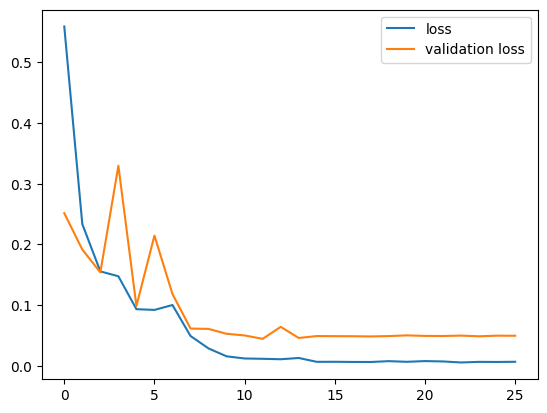

In [13]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()

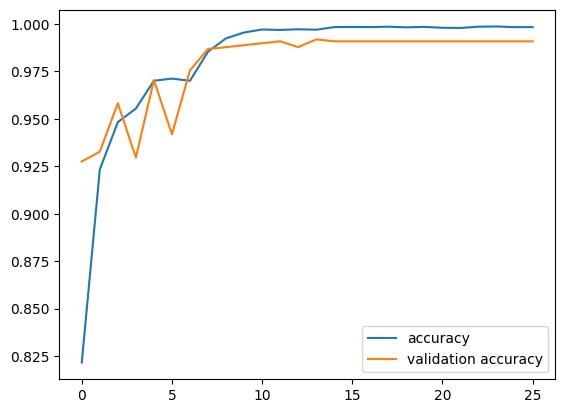

In [14]:
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [15]:
model.evaluate(X_test, y_test, batch_size= 16)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9953 - loss: 0.0169


[0.044789645820856094, 0.9908163547515869]

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


<Axes: >

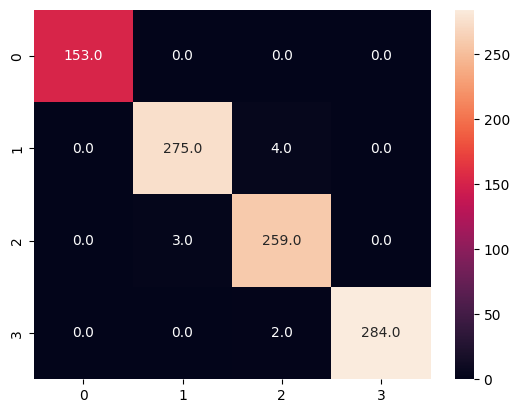

In [22]:
sns.heatmap(tf.math.confusion_matrix(y_test_, y_pred), 
            annot=True, 
            fmt="0.1f")

In [ ]:
model.save("/kaggle/working/fine_tuned_model.h5")
model.save_weights("/kaggle/working/fine_tuned_model.weights.h5")

In [9]:
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split
# import minmaxscaler for scaling the data
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# import various regression models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# import various metrics to evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [10]:
def fitAndEvaluate(model, X_train, y_train, X_test, y_test, grid : list):
    # fit the model on the training data
    model.fit(X_train, y_train)
    # predict the labels of the test data
    accuracies = cross_val_score(estimator= model, X= X_train, y= y_train, cv=10)

    # scale the test data
    # X_test = scaler.transform(X_test)
    y_pred = model.predict(X_test)

    print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    print("Cross validation: Train Score:", np.mean(accuracies))
    print("Cross validation: Test Score:", model.score(X_test, y_test))

    # plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    sns.set(font_scale=1.2) 
    sns.heatmap(cm, annot=True, annot_kws = {"size": 12}, fmt= "0.1f") 
    plt.show()

    print(classification_report(y_test, y_pred))

    # use grid search to find the best parameters
    model_grid = GridSearchCV(model, grid, cv = 5)
    model_grid.fit(X_train, y_train)

    print("Hyperparameters: ", model_grid.best_params_)
    print("Train Score: ", model_grid.best_score_)
    print("Test Score: ", model_grid.score(X_test, y_test))

    # return the model with best parameters
    return model_grid

In [11]:
models = {}

In [12]:
svc = SVC(C=10, kernel='rbf', gamma=1, random_state=0)
grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
models["SVM"] = [svc, grid]

In [13]:
boosted_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
grid = {'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0]}
models["Gradient boosted classifier"] = [boosted_clf, grid]

In [14]:
rfc = RandomForestClassifier(n_estimators=3, random_state=0)
grid = {'n_estimators':np.arange(1,100,1), 'criterion':['gini','entropy']}
models["Random forest Classifier"] = [rfc, grid]

In [15]:
knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
grid = {'n_neighbors':np.arange(1,75), 'p':np.arange(1,5), 'weights':['uniform','distance']}
models["KNN"] = [knn, grid]

In [16]:
model = tf.keras.models.load_model("/kaggle/working/fine_tuned_model.h5")
model.load_weights("/kaggle/working/fine_tuned_model.weights.h5")
model = tf.keras.models.Model(model.input, model.get_layer('Extraction_layer').output)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 394 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [17]:
def get_features(X, model):
    X_ = model.predict(X)
    return X_

In [18]:
X_train_fine_tuned = get_features(X_train, model)
X_test_fine_tuned = get_features(X_test, model)

276/276 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


In [19]:
print(f"X_train_fine_tuned shape -> {X_train_fine_tuned.shape}")
print(f"X_test_fine_tuned shape -> {X_test_fine_tuned.shape}")

X_train_fine_tuned shape -> (8812, 1024)
X_test_fine_tuned shape -> (980, 1024)


In [20]:
results = {}

training the SVM model on the dataset
Model accuracy score : 0.5561
Cross validation: Train Score: 0.528144038546179
Cross validation: Test Score: 0.5561224489795918


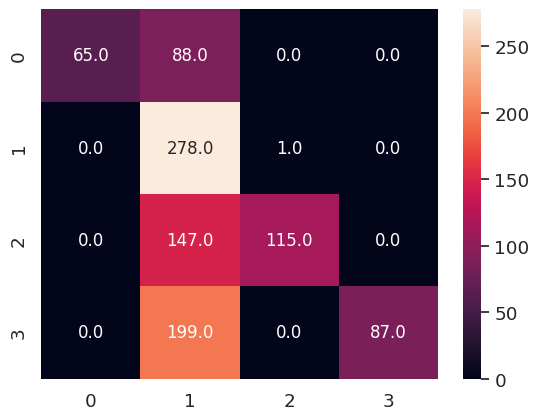

              precision    recall  f1-score   support

           0       1.00      0.42      0.60       153
           1       0.39      1.00      0.56       279
           2       0.99      0.44      0.61       262
           3       1.00      0.30      0.47       286

    accuracy                           0.56       980
   macro avg       0.85      0.54      0.56       980
weighted avg       0.82      0.56      0.55       980



In [ ]:
y_train_ = np.argmax(y_train.copy(), axis=1)
y_test_ = np.argmax(y_test.copy(), axis=1)
for model_name, model_data in models.items():
    print(f"training the {model_name} model on the dataset")
    grid_model = fitAndEvaluate(model_data[0], 
                                X_train_fine_tuned, 
                                y_train_, 
                                X_test_fine_tuned, 
                                y_test_, 
                                model_data[1])
    results[model_name] = grid_model